# Simulating the stochastic unbinding mechanism
In this notebook we present a simulation scheme to model the stochastic unbinding of PR molecules as proposed in our paper. 

### Unbinding mechanism
One of the main results from our paper is that an stochastic unbinding of particles in the context of Brownian motion coalescence can lead to an arrest in the droplets growth. We begin the construction of our simulation functions by defining the unbinding mechanism. In summary, if a droplet contains more than one particle, then its components have a probability $P_u$ of unbinding.

In [1]:
import numpy as np

def escaping_mechanism(label, x, droplet_size,
                       Pu,
                       kick, kick_size, surface):
    ''' This function gets as input the labels of each particles or droplet. If the droplet has more than 
    one particle, we simulates the stochastic unbinding of its components. 
    Args:
        :label (array): array containing the label of each particles / droplet. The label is unique for each
        and is used to control the binding / unbinding of particles. Here, if a particle escapes from a droplet,
        it is given a new label: the maximum current label + 1.
        :x (array): position of the particles. In case of unbinding, this is updated with or without kick (see 
        below).
        :droplet_size (array): size of each of the particles / droplets.
        :Pu (float): unbinding probability.
        :kick (bool): if True, when particles unbind, they get kicked to avoid
                      re-binding).
        :kick_size (float): size of the kick.
        :surface (bool): If surface = True, only the particles in the surface of the 
                         droplet can escape. If False, any particle can escape (see SI
                         of our paper for details).
    Return:
        :new_label (array): updated labels for each particle / droplet after unbinding.
        :upd_x (array): update positions.
        :new_droplet_size (array): updated droplet_size.
    
    '''
    
    new_label = label.copy()
    upd_x = x.copy()
    new_droplet_size = droplet_size.copy()
    
    for l in label:
        if new_droplet_size[l]>1:
            # Get the number of particles in the droplet
            num_parts = round(new_droplet_size[l]**2)

            # Chose the mechanism of escaping. If surface = True, only
            # the particles in the surface of the droplet can escape. If
            # False, any particle can escape (see SI of our paper for details)
            if surface:
                surface_parts = min(num_parts, np.pi*np.sqrt(num_parts))
                coins = np.random.rand(int(surface_parts-1))                  
                escaped = len(coins[coins > Pu])
            else:
                coins = np.random.rand(int(num_parts-1))                  
                escaped = len(coins[coins > Pu])

            # Substracting escaped to the droplet size
            new_droplet_size[l] = np.sqrt(num_parts - escaped)
            # Heralding escaped with -1 label to avoid binding later
            new_droplet_size = np.append(new_droplet_size, np.ones(escaped))
            new_label = np.append(new_label, np.arange(escaped)+new_label[-1]+1)

            # Adding new independent positions for escaped particles. If kick = True,
            # particles receive a kick that move them away from the condensate, to 
            # further avoid re-binding in following steps
            if kick and escaped > 0:
                angle = np.random.rand(escaped)*2*np.pi
                news = np.vstack(x[l,0]+(np.cos(angle)*(new_droplet_size[l]+kick_size), # X component
                                 x[l,1]+np.sin(angle)*(new_droplet_size[l]+kick_size))).transpose() # Y component
                upd_x = np.vstack((upd_x,news))
            else:                    
                news = upd_x[l,:].repeat(escaped, axis = 0).reshape(2,escaped).transpose()
                upd_x = np.vstack((upd_x,news))
                
    return new_label, upd_x, new_droplet_size

## Time evolution
Below is the main function for the temporal evolution of a systems performing a BMC process with the stochastic unbinding presented in our paper and defined in the previous function. 

In [2]:
from tqdm.auto import tqdm

def stochastic_unbinding(N, T, r, L,
                         D, Pu = 1,
                         kick = False, kick_size = 0,
                         surface = False):
    ''' This functions performs the simulation of a Brownian Motion Coalescence mechanism
    with stochastic unbinding of its particles. Particles inside the condensate will always
    bind with probability 1, while they have probability Pu of unbinding
    
    Args:
        :N (int): number of particles.
        :T (int): number of time steps of the simulation.
        :r (float): size of single particles.
        :L (float): size of the box acting as the environment (periodic boundary 
                    conditions apply).
        :D (float): diffusion coefficient of free particles.
        :kick (bool): see function escaping_mechanism
        :kick_size (float): see function escaping_mechanism
        :surface (bool): see function escaping_mechanism
    Returns:
        :dist_droplet_size (list): list containing the distribution of droplet size at 
                                   each time step.
        :mean_droplet_size (array): array containing the mean size of the droplets at 
                                    each time step.
    '''
    

    ### Initial positions and droplet sizes (all free particles)
    x = np.random.rand(N, 2)*L    
    droplet_size = np.ones(N)

    ### Variables for saving data
    dist_droplet_size = []
    mean_droplet_size = np.ones(T)*N  

    ### Evolution ####
    for t in (range(T)):
        
        label = np.arange(x.shape[0])
        max_label = label[-1]

        ### Updating labels and positions after unbinding
        label, x, droplet_size = escaping_mechanism(label, x, droplet_size,
                                      Pu,
                                      kick, kick_size, surface)

        ### Calculating distances between particles
        M = np.reshape(np.repeat(x[ :, :], x.shape[0], axis = 0), (x.shape[0], x.shape[0], 2))
        Mtrans = M.transpose(1,0,2)
        distance = np.sqrt(np.square(M[:,:, 0]-Mtrans[:,:, 0])
                         + np.square(M[:,:, 1]-Mtrans[:,:, 1]))  
        # Increasing artificially distance of escaped to avoid re-binding 
        distance[label > max_label, :] = 2*L
        distance[:, label > max_label] = 2*L  

        ### Creating droplets ###
        for n, s in enumerate(droplet_size[:max_label+1]):
            distances_adapted = distance[n,:]-droplet_size
            distances_adapted[n] == 0
            close_particles = np.argwhere(distances_adapted < s*r).flatten()
            # Update the label to the one of first particle in condensate
            label[distance[n,:] < s*r] = label[n]
            

        ### Merging droplets
        u_labels = np.unique(label)
        new_droplet_size = np.zeros(len(u_labels))
        avg_pos = np.zeros((len(u_labels), 2)) 
        for idx_c, l in enumerate(u_labels):
            # Find the particles sharing label (i.e. in same droplet)
            parts_in_cond = x[label == l, :]
            size_in_cond = droplet_size[label == l]
            # Define position of droplet as the center of mass between all
            # the constituents
            avg_pos[idx_c, :] = np.mean(parts_in_cond, axis = 0)   
            # Recalculate its size
            new_droplet_size[idx_c] =  np.sqrt(np.sum(size_in_cond**2))

        ### Droplet displacement
        disp = D*np.random.randn(avg_pos.shape[0],2)                
        # Adding displacement considering stokes drag
        new_x = avg_pos + (disp.transpose()*(1/new_droplet_size)).transpose()

        
        ### Saving data for anaylysis
        dist_droplet_size.append(new_droplet_size) 
        mean_droplet_size[t] = np.mean(new_droplet_size)
        
        ### Updating position, sizes and consider periodic boundary conditions
        x = new_x
        droplet_size = new_droplet_size
        while np.max(x)>L or np.min(x)< 0: 
            x[x > L] = x[x > L]-L
            x[x < 0] = L + x[x < 0]  

               
    
    return mean_droplet_size, dist_droplet_size
    

## Results with small numbers of particles
We now showcase some of the results that can be achieved with the previous function. Note that, for the sake of not spending hours calculating, we will consider a small number of particles and short times. This means that the scalings will difer from the ones calculated in the paper, as we will suffer from finite size effects.

In [3]:
N = 15         # Number of particles
r = 1          # Radius of interaction
T = int(1e2)   # Length of simulations
S = N/0.05     # Total area, calculate as function of density
L = np.sqrt(S) # Length of the environment box
D = 1          # Diffusion coefficient of particles

reps = 36      # Number of repetitions

# We will sweap over various unbinding probabilities to see their effect on the BMC process.
Pus = np.append(1-np.logspace(-1, -3, 5), 1)

Now let's simulate the system. To speed things up, we will use the `joblib` library to parallelize the simulations. Depending on your compuational capabilities, you may want to increase the number of repetitions, length of the simulation or the number of particles in the system. 

In [4]:
from joblib import Parallel, delayed

mean_size_pu = np.zeros((reps, len(Pus), T))

for idx, Pu in enumerate(tqdm(Pus)):
    
    for idx_r in tqdm(range(reps)):
        
        mean_size_pu[idx_r, idx, :], _ = stochastic_unbinding(N = N, T = T, r = r, L = L, D = D, Pu = Pu, kick = True)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Now we can plot the results:

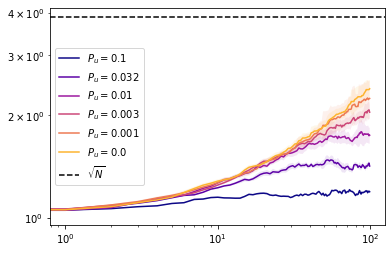

In [5]:
import matplotlib.pyplot as plt
plasma = plt.cm.get_cmap('plasma', mean_size_pu.shape[1]+1); colors = plasma(range(mean_size_pu.shape[1]))

fig, ax = plt.subplots()
for idx, mean_size in enumerate(mean_size_pu.transpose(1, 0, 2)):
    mean = mean_size.mean(0)
    var = mean_size.var(0)
    
    ax.loglog(np.arange(T), mean, c = colors[idx], label = fr'$P_u = {np.round(1-Pus[idx], 3)}$')
    ax.fill_between(np.arange(T), mean-var, mean+var, facecolor = colors[idx], alpha = 0.1)

ax.axhline(np.sqrt(N), ls = '--', c  = 'k', label = r'$\sqrt{N}$')
ax.legend() 

As you can see, with few repetitions the results are quite noisy. As an example, below are the results obtained for the same system but 360 repetitions (`reps = 360`) and longer times (`T=1e3`):

<center>
<img src="long_simulations.png" alt="drawing" width="300"/>
<center>
